# Behavioral Cloning

In [23]:
import cv2 as cv
import os
#import time
import tensorflow as tf
import numpy as np
import pandas as pd

import h5py

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import sample

# Simple Network
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D



## Image Processing Functions


In [ ]:
# Multiple (camera) images as input
def read3camerasImg(pathCenter, pathLeft, pathRight, steering, steerAdj = 0.2):
    """
    input: 
        "pathCenter", "pathLeft" and "pathRight" are all (nx1) vector of strings, containing the path
        of the saved image
        example: pathCenter[0], pathLeft[0] and pathRight[0]
        C:\SelfDrivingCarNanodegree\3BehavioralCloning\data\IMG\center_2018_04_05_13_39_08_155.jpg
        C:\SelfDrivingCarNanodegree\3BehavioralCloning\data\IMG\left_2018_04_05_13_39_08_155.jpg
        C:\SelfDrivingCarNanodegree\3BehavioralCloning\data\IMG\right_2018_04_05_13_39_08_155.jpg
        
        "steering" is a vector of double for the steering angle. Left steering is positive, right is negative
        example: steeing[0] = -0.36
    output:
        X, images in numpy array of (n, h, w, d)
        y, steer value in numpy array of size (n, )
    
    """
    assert len(pathCenter) == len(pathLeft) == len(pathRight) == len(steering)
    images3 = []
    steer = []

    nim = len(pathCenter)
    for i in range(nim):
        imgC = cv.cvtColor(cv.imread(xCenter[i]), cv.COLOR_BGR2RGB)
        imgL = cv.cvtColor(cv.imread(xLeft[i]), cv.COLOR_BGR2RGB)
        imgR = cv.cvtColor(cv.imread(xRight[i]), cv.COLOR_BGR2RGB)
        
        # convert 
        # correct steering angle (y) for lect image and right image
        yC = steering[i]
        yL = steering[i] + steerAdj
        yR = steering[i] - steerAdj
        images3.extend([imgC, imgL, imgR])
        steer.extend([yC, yL, yR])
        if (i%1000==0): print("Images imported: " + str(i) + "x 3")
        
    y = np.array(steer)
    X = np.array(images3)
    
    return X, y



In [ ]:
def flipBatchImg(images, measurement):
    """
    Create a new Augment batch images with flipped image
    Input:  images:          (n, w, d, 3)
            measurement:     (n, )
    """
    # data augmentation: Flipped image
    
    assert images.shape[0] == measurement.shape[0]
    
    fImages = []
    fMeasurement = []
    
    for i, img in enumerate(images):
        image_flipped = np.fliplr(img)
        measurement_flipped = - measurement[i]
        fImages.append(image_flipped)
        fMeasurement.append(measurement_flipped)
        if (i%1000==0): print("Images flipped: " + str(i))
        
    newImages = np.array(fImages)
    newMeasurement = np.array(fMeasurement)
        
    return newImages, newMeasurement


## Data

In [3]:
pathdata = "../data/"

cnames = ['centerIm', 'leftIm','rightIm','steer','throttle','brake','speed']
df = pd.read_csv(pathdata+"driving_log.csv", names=cnames)
# df.head()

# Read center image
xCenter = df['centerIm']
xLeft  = df['leftIm']
xRight = df['rightIm']
ysteer = df['steer']


In [ ]:

# Save example images in example directory
expath = "example/"
if not os.path.isdir(expath): os.makedirs(expath)

# Note: cv has default BGR. As I read with BGR and write with BGR, no need of color conversion
imgC = cv.imread(xCenter[123])
imgL = cv.imread(xLeft[123])
imgR = cv.imread(xRight[123])
cv.imwrite(expath + "cameraLeft.png", imgL)
cv.imwrite(expath + "cameraRight.png", imgR)
cv.imwrite(expath + "cameraCenter.png", imgC)

fig = plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(imgL)
plt.subplot(1,3,2)
plt.imshow(imgC)
plt.subplot(1,3,3)
plt.imshow(imgR)


In [ ]:
X, y = read3camerasImg(xCenter, xLeft, xRight, steering=ysteer, steerAdj=0.2)


n = X.shape[0]
#sample without replacement. add 1/4 sample where each image is flipped
select = sample(range(n), int(n/4))

x1, y1 = flipBatchImg(X[select,], y[select,])
X = np.concatenate((X,x1))
y = np.concatenate((y,y1))

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# save once
# h5f = h5py.File("drivingData.h5", "w")
# h5f.create_dataset("dataset_X", data = X)
# h5f.create_dataset("dataset_y", data = y)
# h5f.close

## Model

In [4]:
# Load data back
h5f = h5py.File("drivingData.h5", "r")
X = h5f["dataset_X"][:]
y = h5f["dataset_y"][:]

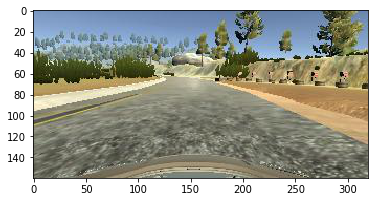

In [5]:
plt.imshow(X[123,])

In [28]:
inputShape = X[0,].shape
inputShape

(160, 320, 3)

In [52]:
def MyKerasArchitecture(inputShape):
    ## Initiate Keras Model and crop data
    input0 = Input(inputShape)
    layer0 = Lambda(lambda x: x/255.0 - 0.5)(input0)

    layer01 = Cropping2D(cropping = ((60,20), (0,0)))(layer0)

    # Convolution and Max Pooling layers
    layer1 = Conv2D(9, (6,6), padding='valid', activation = "relu")(layer01)
    layer2 = MaxPooling2D(pool_size=(2,2), padding="valid")(layer1)

    layer3 = Conv2D(27, (6,6), padding='valid', activation = "relu")(layer2)
    layer4 = MaxPooling2D(pool_size=(2,2), padding="valid")(layer3)

    layer5 = Conv2D(81, (6,6), padding='valid', activation = "relu")(layer4)
    layer6 = MaxPooling2D(pool_size=(2,2), padding="valid")(layer5)
    
    layer7 = Conv2D(81, (3,3), padding='valid', activation = "relu")(layer6)

    # Dropout
    #layer8 = Dropout(0.2)(layer7)

    # Flat layer 
    layer8 = Flatten()(layer7)

    # relu(xw +b) of Fully connected layers
    layer9 = Dense(200, activation = "relu")(layer8)
    layer10 = Dense(50, activation = "relu")(layer9)
    layer11 = Dense(1)(layer10)
    
    model = Model(inputs=input0, outputs=layer11)
    
    return model


In [54]:
mymod4 = MyKerasArchitecture(inputShape)
mymod4.compile(loss="mse", optimizer="adam")

In [55]:
mf = mymod4.fit(X, y, validation_split=0.2, shuffle=True, epochs = 4)
mymod4.save("model4.h5")

Train on 27300 samples, validate on 6825 samples
Epoch 1/4
27300/27300 [==============================] - 2886s 106ms/step - loss: 0.0309 - val_loss: 0.0352
Epoch 2/4
27300/27300 [==============================] - 2921s 107ms/step - loss: 0.0261 - val_loss: 0.0341
Epoch 3/4
27300/27300 [==============================] - 2946s 108ms/step - loss: 0.0227 - val_loss: 0.0454
Epoch 4/4
27300/27300 [==============================] - 3025s 111ms/step - loss: 0.0202 - val_loss: 0.0647


In [56]:
mymod4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_12 (Cropping2D)   (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 315, 9)        981       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 37, 157, 9)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 152, 27)       8775      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 76, 27)        0         
__________

In [49]:
## Visualize Loss

### print the keys contained in the history object
# print(mf.history.keys())
# print(mf.history)
# print(mf)


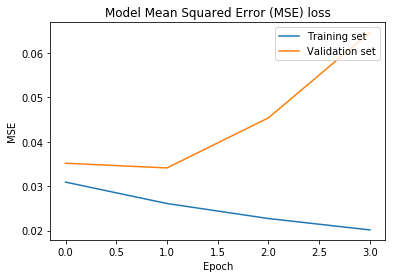

In [57]:
### plot the training and validation loss for each epoch
plt.plot(mf.history['loss'])
plt.plot(mf.history['val_loss'])
plt.title('Model Mean Squared Error (MSE) loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()

In [ ]:


# # Data preprocessing. 
# ## normalize. Improve substantially
# model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape = (160,320,3)) )

# ## Cropping. Remove top 60 pixels and bottom 20 pixels
# model.add(Cropping2D(cropping = ((50,20), (0,0))))

# # MyNet architecture
# model.add(Conv2D(9, (10,10), padding='valid', activation = "relu"))
# model.add(MaxPooling2D())

# # 5x5 convolution, 6 filters
# model.add(Conv2D(27, (6,6), padding='valid', activation = "relu"))
# model.add(Conv2D(27, (3,3), padding='valid', activation = "relu"))
# model.add(MaxPooling2D())

# # Flat layer 
# model.add(Flatten())

# # relu(xw +b)
# model.add(Dense(100, activation = "relu"))
# model.add(Dense(50, activation = "relu"))
# model.add(Dense(1))

# model.compile(loss="mse", optimizer="adam")

# mf = model.fit(X, y, validation_split=0.2, shuffle=True, epochs = 4)
# model.save("model2.h5")


In [ ]:

# # reload model
# from keras.models import load_model
# model1 = load_model("model1.h5")

# model1.fit(X, y, validation_split=0.2, shuffle=True, epochs = 5)